
# Graphics Cards Pricing : How the launch of one of the most prospective family of cards ended up as customers' worst experience in recent history




## (1) The background, aim and objective of this research



### (1.1) Background


As somewhat of a nerd that loves both software and hardware in the IT industry. PC building can be considered as somewhat of a hobby of mine. Back in May 2020, Nvidia announced the launch of their Ampere line of Graphics Cards, with the RTX 3080 reportedly having a <b>50% increase in performance over Nvidia's last-gen flagship</b>, the RTX 2080Ti, while being about 30% cheaper (<b>699 USD</b> vs <b>999 USD</b>), giving consumers better value at a much higher performance-per-dollar.

However, as great as these Graphics Cards were on paper, the launch quickly devolved into what was known <i>as the worst of all time</i> due to a multitude of issues that plagued both the availability and pricing of these cards. Leading them to be <b>scalped/sold for more than 2 times</b> their cost price.
 
Therefore, in this research piece, I would like to document and provide some backstory on how the family of cards that was supposed to go down as one of the best Nvidia has made in history, became known as one of its worst.
 
 



### (1.2) Aims and Objectives

 Within this project, my objectivces are to help the reader understand,
 
 - Pros of the Ampere Family of Graphics Cards,
     - Pricing
     - Performance
     - Benchmarks
     - Value
     
 - Reasons why the run of these Graphics Cards were terrible,
 
     - Scalping
     - Chip Shortages
     - Crypto Currency
     - Covid-19 Pandemic
     
 - How the situation has improved
 
 
 Within this project, my aim is to,
 
 1. Give some analytics and statistics of this family of Graphics Cards
 2. Webscrape the pricing of these cards over time since its launch
 3. Clean and tranform the data so that it is more coherent and suitable for my uses
 4. Plot the data in a way I would be able to view the trends of its pricing and other metrics

## (2) The Datasets used

### (2.1) Sources of the data I am using

<a href="https://www.techpowerup.com/gpu-specs/">GPU Database</a>, I'm using TechPowerUps' GPU database to retrieve and scrape for the data that I need, I had initially intended to use Nvidia's own website, but their HTML elements were very messy and I was having trouble sorting through for the data I needed.

Game Benchmarks
(?)

Semi-Conductor Shortage,
https://www.kaggle.com/datasets/ramjasmaurya/semiconductor-shortages19852021

CryptoCurrency Pricing,
https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory

### (2.2) Limitations of the data I am using

### New Launches have happened

Although I am comparing the performance of the Ampere, Pascal and Maxwell2.0 families of cards, the 40 Series (Ada Lovelace) has since launched, but at the current time of me writing this, it is a very new family that just launched back in Oct 2022. Thus, i have omitted any comparisons to that family as i feel that the comparison will be unfair as streneous testing and reviews for that family is still not as extensive as the previous generations.

## (3) Requirements

### (3.1) Importing relevant libraries

In [74]:
import pandas as pd
# import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import json
# from pandas import json_normalize
import matplotlib.pyplot as plt

### (3.2) Scraping of Data and writing to JSON

<h3>Example Requests using the request and bs4 libraries</h3>

In [73]:
# Fetching the specifications of the RTX 3080
r = requests.get("https://www.nvidia.com/en-us/geforce/graphics-cards/30-series/rtx-3080-3080ti/")
# Fetching status code of req, 200 means OK and 404 means not found
r.status_code
# Fetching datatype, for example 'text/html, charset="utf-8"'
r.headers['content-type']
# Find out character encoding of page
r.encoding
#  Fetching raw content of the page
r.text

<h3>Constructing the BeautifulSoup Obj</h3>

In [6]:
# Setting up BeautifulSoup to fetch data i need
def get_soup(URL, jar=None):
    request_headers = {
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:50.0) Gecko/20100101 Firefox/50.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,/;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate, br"

    }

    if jar:
        r = requests.get(URL, cookies=jar, headers=request_headers)
    else:
        r = requests.get(URL, headers=request_headers)
        jar = requests.cookies.RequestsCookieJar()
    print("Data scrapped from : ", r.url)
    data = r.text
    soup = BeautifulSoup(data, "html.parser")
    return soup, jar

In [7]:
# Test bs4 req to check if link works
soup, jar = get_soup("https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621")

# Check if the BeautifulSoup obj has an attribute within
if hasattr(soup, 'attr_name'):
    print("Soup is ready for consumption. Check the link above to be sure! ")

Data scrapped from :  https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621
Soup is ready for consumption. Check the link above to be sure! 


<h3>Functions to help me scrape the data i need</h3>

In [97]:
def fetch_card_specs(soup, class_type, class_data):
    t_results = soup.find_all("dt", class_type)
    d_results = soup.find_all("dd", class_data)
    card_specs = {}
    for field, data in zip(t_results, d_results):
        card_specs[field.text] = data.text
    
    return card_specs

# This was done seperately from the base card specs as the HTML i scrapped this from
# used a reusable container with no explicit classname or id, leading me to use regex
def fetch_physical_specs(soup, card_dict):
    # Regex checks for matching label name and fetches the attribute after it
    base_clock  = soup.find('dt', text = re.compile('^Base\sClock')).findNext('dd').contents[0]
    card_dict["Base Clock"] = base_clock
    
    
    boost_clock  = soup.find('dt', text = re.compile('^Boost\sClock')).findNext('dd').contents[0]
    card_dict["Boost Clock"] = boost_clock
    
    
    amt_cores = soup.find('dt', text = re.compile('^CUDA')).findNext('dd').contents[0]
    card_dict["CUDA Cores"] = amt_cores
    
    bandwidth = soup.find('dt', text = re.compile('^Bandwidth')).findNext('dd').contents[0]
    card_dict["Memory Bandwidth"] = bandwidth.strip() # String contained whitespaces so i removed them using .strip()
    
    
    # Checks if card gen supports ray tracing     
    ray_tracing = True
    rt_cores = soup.find('dt', text = re.compile('^RT\sCores'))
    if rt_cores is None:
        ray_tracing = False
        card_dict["Ray Tracing Capable(?)"] = ray_tracing
    else:
        card_dict["Ray Tracing Capable(?)"] = ray_tracing
    
    
    total_draw = soup.find('dt', text = re.compile('^TDP')).findNext('dd').contents[0]
    card_dict["TDP"] = total_draw
    
    
    launch_price = soup.find('dt', text = re.compile('^Launch\sPrice')).findNext('dd').contents[0]
    card_dict["Launch Price (USD)"] = launch_price

    
def write_to_JSON(data):
    with open("Cards.json", "a", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False)
        f.write("\n")

In [112]:
# List of dictinaries that will be written to JSON
card_list = {}

In [113]:
# RTX 3080 Card Specifications
soup, jar = get_soup("https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621")

# Fetch Card Specs
rtx_3080 = fetch_card_specs(soup, {"class": "gpudb-specs-large__title"}, {"class": "gpudb-specs-large__value"})

# Fetch Card Clock Speeds, tenser/RT cores and TDP
fetch_physical_specs(soup, rtx_3080)

# Construct DataFrame using dictionary keys as column names
df = pd.DataFrame.from_dict(rtx_3080, orient='index', columns=['Nvidia Geforce RTX 3080'])

# Append to a list and dump all the data into JSON
card_list["Nvidia Geforce RTX 3080"] = rtx_3080

df

Data scrapped from :  https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621


,Nvidia Geforce RTX 3080
Graphics Processor,GA102
Cores,8704
TMUs,272
ROPs,96
Memory Size,10 GB
Memory Type,GDDR6X
Bus Width,320 bit
Base Clock,1440 MHz
Boost Clock,1710 MHz
CUDA Cores,8.6


In [114]:
# RTX 2080 Card Specifications
soup, jar = get_soup("https://www.techpowerup.com/gpu-specs/geforce-rtx-2080.c3224")

# Fetch Card Specs
rtx_2080 = fetch_card_specs(soup, {"class": "gpudb-specs-large__title"}, {"class": "gpudb-specs-large__value"})

# Fetch Card Clock Speeds
fetch_physical_specs(soup, rtx_2080)

# Construct DataFrame using dictionary keys as column names
df = pd.DataFrame.from_dict(rtx_2080, orient='index', columns=['Nvidia Geforce RTX 2080'])

# Append to a list and dump all the data into JSON
card_list["Nvidia Geforce RTX 2080"] = rtx_2080

df

Data scrapped from :  https://www.techpowerup.com/gpu-specs/geforce-rtx-2080.c3224


,Nvidia Geforce RTX 2080
Graphics Processor,TU104
Cores,2944
TMUs,184
ROPs,64
Memory Size,8 GB
Memory Type,GDDR6
Bus Width,256 bit
Base Clock,1515 MHz
Boost Clock,1710 MHz
CUDA Cores,7.5


In [115]:
# GTX 1080 Card Specifications
soup, jar = get_soup("https://www.techpowerup.com/gpu-specs/geforce-gtx-1080.c2839")

# Fetch Card Specs
gtx_1080 = fetch_card_specs(soup, {"class": "gpudb-specs-large__title"}, {"class": "gpudb-specs-large__value"})

# Fetch Card Clock Speeds
fetch_physical_specs(soup, gtx_1080)

# Construct DataFrame using dictionary keys as column names
df = pd.DataFrame.from_dict(gtx_1080, orient='index', columns=['Nvidia Geforce GTX 1080'])

# Append to a list and dump all the data into JSON
card_list["Nvidia Geforce GTX 1080"] = gtx_1080

df

Data scrapped from :  https://www.techpowerup.com/gpu-specs/geforce-gtx-1080.c2839


,Nvidia Geforce GTX 1080
Graphics Processor,GP104
Cores,2560
TMUs,160
ROPs,64
Memory Size,8 GB
Memory Type,GDDR5X
Bus Width,256 bit
Base Clock,1607 MHz
Boost Clock,1733 MHz
CUDA Cores,6.1


In [116]:
# GTX 980 Card Specifications
soup, jar = get_soup("https://www.techpowerup.com/gpu-specs/geforce-gtx-980.c2621")
# Fetch Card Specs
gtx_980 = fetch_card_specs(soup, {"class": "gpudb-specs-large__title"}, {"class": "gpudb-specs-large__value"})
# Fetch Card Clock Speeds
fetch_physical_specs(soup, gtx_980)

# Construct DataFrame using dictionary keys as column names
df = pd.DataFrame.from_dict(gtx_980, orient='index', columns=['Nvidia Geforce GTX 980'])

# Append to a list and dump all the data into JSON
card_list["Nvidia Geforce GTX 980"] = gtx_980

df

Data scrapped from :  https://www.techpowerup.com/gpu-specs/geforce-gtx-980.c2621


,Nvidia Geforce GTX 980
Graphics Processor,GM204
Cores,2048
TMUs,128
ROPs,64
Memory Size,4 GB
Memory Type,GDDR5
Bus Width,256 bit
Base Clock,1127 MHz
Boost Clock,1216 MHz
CUDA Cores,5.2


In [117]:
# Write to JSON file
write_to_JSON(card_list)

In [118]:
file = open('Cards.json')
dataframe = json.load(file)
cards_data = pd.DataFrame.from_dict(dataframe)
cards_data

,Nvidia Geforce RTX 3080,Nvidia Geforce RTX 2080,Nvidia Geforce GTX 1080,Nvidia Geforce GTX 980
Graphics Processor,GA102,TU104,GP104,GM204
Cores,8704,2944,2560,2048
TMUs,272,184,160,128
ROPs,96,64,64,64
Memory Size,10 GB,8 GB,8 GB,4 GB
Memory Type,GDDR6X,GDDR6,GDDR5X,GDDR5
Bus Width,320 bit,256 bit,256 bit,256 bit
Base Clock,1440 MHz,1515 MHz,1607 MHz,1127 MHz
Boost Clock,1710 MHz,1710 MHz,1733 MHz,1216 MHz
CUDA Cores,8.6,7.5,6.1,5.2


### The Specifications and what they mean

### Memory Size and Type

In [140]:
mem_data = cards_data.loc[["Memory Size", "Memory Type", "Memory Bandwidth"]]
mem_data

,Nvidia Geforce RTX 3080,Nvidia Geforce RTX 2080,Nvidia Geforce GTX 1080,Nvidia Geforce GTX 980
Memory Size,10 GB,8 GB,8 GB,4 GB
Memory Type,GDDR6X,GDDR6,GDDR5X,GDDR5
Memory Bandwidth,760.3 GB/s,448.0 GB/s,320.3 GB/s,224.4 GB/s


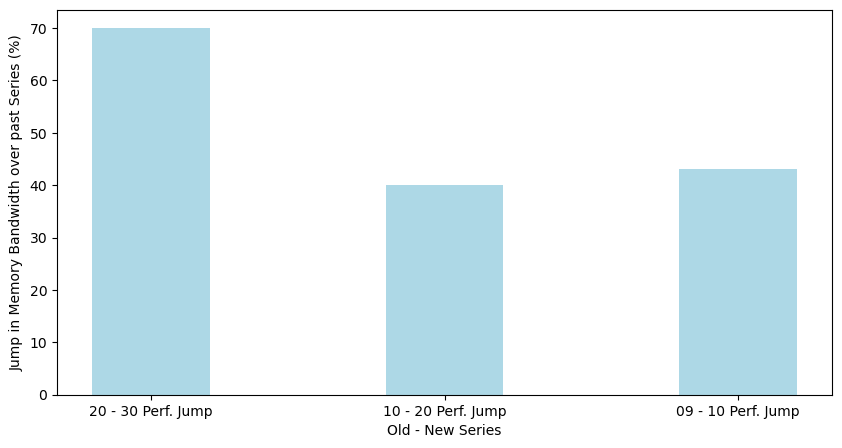

In [202]:
def plot_bandwidth(mem_data):
    t_bandwidth = []
    bandwidth_comp = []
    for bw_str in mem_data.loc["Memory Bandwidth"]:
        # Strip 'GB/s' from data to use in plotting of graph      
        bandwidth = re.sub(r'[^0-9.]', '', bw_str)
        t_bandwidth.append(bandwidth)
        
    for i in range(len(t_bandwidth)):
        if(i + 1 < len(t_bandwidth)):
            percentage_diff = (float(t_bandwidth[i]) / float(t_bandwidth[i + 1])) - 1
            bandwidth_comp.append(round(percentage_diff, 2) * 100)
    
    # creating the barchart
    barchart_data = {'20 - 30 Perf. Jump':bandwidth_comp[0], '10 - 20 Perf. Jump':bandwidth_comp[1],
                     '09 - 10 Perf. Jump':bandwidth_comp[2]}
    x_col = list(barchart_data.keys())
    y_col = list(barchart_data.values())
    
    fig = plt.figure(figsize = (10, 5))
    plt.ylabel('Jump in Memory Bandwidth over past Series (%)')
    plt.xlabel('Old - New Series')
        
    # creating the bar plot
    plt.bar(x_col, y_col, color ='lightblue',
            width = 0.4)
    
plot_bandwidth(mem_data)

As can be seen in the table above the RTX 3080 features 10 GB of GDDR6X memory, 1 specification above the older GDDR6, with an additional 2 GB to boot. In terms of its available bandwith, this newer specification saw a approximately 70% increase in bandwidth from the RTX 2080, compared to the average of 40% from the GTX 980 through RTX 2080.

### Show benchmarks to explain the performance for dollar value of the 30 gen over the older gen

3080 Time Spy Graphics Benchmark Score, take avg of top 20 and find mean score
https://www.3dmark.com/search?_ga=2.64763439.1073537459.1670388667-548251550.1670388667#advanced?test=spy%20P&cpuId=&gpuId=1338&gpuCount=0&gpuType=ALL&deviceType=ALL&storageModel=ALL&memoryChannels=0&country=&scoreType=graphicsScore&hofMode=false&showInvalidResults=false&freeParams=&minGpuCoreClock=&maxGpuCoreClock=&minGpuMemClock=&maxGpuMemClock=&minCpuClock=&maxCpuClock=

2080 Time Spy Graphics Benchmark Score, take avg of top 20 and find mean score
https://www.3dmark.com/search?_ga=2.64763439.1073537459.1670388667-548251550.1670388667#advanced?test=spy%20P&cpuId=&gpuId=1208&gpuCount=1&gpuType=ALL&deviceType=ALL&storageModel=ALL&memoryChannels=0&country=&scoreType=overallScore&hofMode=false&showInvalidResults=false&freeParams=&minGpuCoreClock=&maxGpuCoreClock=&minGpuMemClock=&maxGpuMemClock=&minCpuClock=&maxCpuClock=

### History of what caused these series to be bad (crypto, covid, chip shortage)

### Show trends of crypto price, chip shortage overtime and inflated price of GPU